<img src="../../../images/qiskit-heading.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Implementation of Quantum Walks on Cycle Graph
This notebook is based on the paper of  B L Douglas and J B Wang, "Efficient quantum circuit implementation of quantum walks", arXiv:0706.0304 [quant-ph].

## Contributors
Jordan Kemp (University of Chicago), Shin Nishio (Keio University), Ryosuke Satoh (Keio University), Desiree Vogt-Lee (University of Queensland), and Tanisha Bassan (The  Knowledge Society)

## Introduction

There are many different types of quantum walks: a walker can walk on n-dimensional space or any limited graphs. First we will talk about the concept and dynamics of the quantum random walk and then show the implementation of a quantum walk on cycle graph.

## Random walk 
A random walk is a dynamical path with a randomly evolving time system. The figure below shows a simple type of random walk. 

<img src="../images/quantum_walk/random_walk.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="center">

The dynamics can be regarded as a simple algorithm:
1. There is a $n$-dimensional space (in this case, one for simplicity) and a walker which starts at the point $x=0$
2. The walker then takes a step either forwards (towards $+x$) or backwards (towards $-x$) 

In the second step, the choice is made randomly (eg. a coin-flip). We can call this the "Coin Operator". 

For this system: $p+q = 1$.

## Quantum Walk 
A quantum walk is the "quantum version" of a classical random walk. This means the coin function will be a Unitary gate ($U(2)$) which is non-random and reversible:

$$p+q = U \in U(2)$$

In this notebook, we use a Hadamard gate for executing the coin function since it puts our qubits in a state of superposition, allowing for the  simulation of a coin based probability:

$$H=\frac{1}{\sqrt{2}}\left [{\begin{array}{rr}1 & 1 \\ 1 & -1\\ \end{array}}\right]$$

There are two kinds of random walks, continuous and discrete, and in this notebook we will use the discrete framework. In the discrete, unitary operations are made of coin and shift operators $U = SC$ which work in a state space.

It is represented by an arbitrary undirected graph $G(V,E)$ where $V = {v_1, v_2, ..v_n}$ as nodes on the graph and $E = {(v_x, v_y) , ( v_i, v_j) …}$ as edges that combine different nodes together.

The quantum walk extends into a position space where each node $v_i$ has a certain valency $d_i$ and is split into $d_i$ subnodes. The shifting operator then acts as $S (v_i, a_i) = (v_j, a_j)$ and with the coin operator, are unitary gates which combine the probability amplitudes with individual subnodes under each node.

A unitary of $v_i$ with valency $d_i$ can be represented as $(d_i \times d_i)$. The total state of system is defined by the Hilbert space 

$$H = H_c + H_p$$ 

Where $H_C$ is the coin Hilbert space and $H_P$ is the position Hilbert space. 

## The Coin Operator 
The first operation in a quantum random walk is the coin operator. The operator works by performing an arbitrary unitary transformation in the coin space which creates a rotation similar to “coin-flip” in random walk. This is namely the Hadamard gate, which models a balanced unitary coin. 

The coin register will continue interfering with its position state until it is measured, after all intermediate steps. The results are very different from random walks as it doesn’t converge to a Gaussian distribution, but rather evolves into an asymmetric probability distribution. This happens because the Hadamard coin operator treats each basis vectors, |↑> and |↓> , differently. 

The rightwards path interferes more destructively as it is multiplied by -1, however, the leftwards path undergoes more constructive interference and the system tends to take steps towards the left. To reach symmetric results, both base vectors will start in a superposition of states (between  |↑> and |↓>). Another way to reach symmetry is use a different coin operator which doesn’t bias the coin towards a certain base vector, such as the Y gate:

$$Y=\frac{1}{\sqrt{2}}\left [{\begin{array}{rr}1 & i \\ i & 1\\ \end{array}}\right]$$

## Quantum Walk on the Cycle Graph

The goal of this notebook is to conduct a quantum random walk on circular graph which can be efficiently and simply implemented on the quantum circuit. The graph has 8 nodes with 2 attached edges which act as the subnodes on the circuit. 

<img src="../images/quantum_walk/8_white.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="350 px" align="center">

The operations propagate systemically around the graph as each node is a seperate bit-string value in lexicographic order. For a 2n graph, n qubits are required to encode the problem and 1 ancilla qubit is required for the subnode (coin). 

<img src="../images/quantum_walk/whole_circuit.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="700 px" align="center">

The above circuit shows the whole process of the quantum walk on a cycle graph with $2^3$ nodes. 

The gray rectangular frame outlines a set of coin operators and shift operators. 

In this circuit, q[0] to q[2] represent the state (position) of quantum walker, and q[3] represents the coin operator.

In this style, a programmer can insert the initial position of walker as a 3-qubit state. For example, if the input is $110$, then the position is $6$ (see the earlier cycle graph). 

The coin operator decides whether the walker proceeds clockwise or counterclockwise.

INC is a gate that increments the state of the walker which is equal to a clockwise rotation in the cycle graph. 

DEC is gate that decrements the state of the walker which is equal to a counterclockwise rotation in cycle graph.

After repeatedly executing the coin operator and the shift operator, we can measure the qubits (excluding the ancilla coin qubit), and it is then possible to know the position of the walker.

## $n$-qubit Toffoli

The Toffoli gate is a CCNOT(CCX) gate. By using the Toffoli gate, X gates executed on Q2 if Q0 and Q1 is equal to 1.

In our quantum walk implementation, we need more connections to expand the quantum walk implementation.

<img src="../images/quantum_walk/toffoli.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="center">

For example, CCX can be written as in the below circuit by using only the available gate sets of the IBMQ devices.

Therefore, for more than 4 qubits, we can implement many qubits of CX gate ("C$N$X gate") using this method. Reference shown [here]("https://journals.aps.org/pra/abstract/10.1103/PhysRevA.52.3457").

<img src="../images/quantum_walk/implement_toffoli.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="center">

C$N$X can be represented using C($N-1$)X as shown.

In [1]:
def cnx(qc, *qubits):
    if len(qubits) >= 3:
        last = qubits[-1]
        # A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        qc.cu3(np.pi/2, 0, 0, qubits[-2],qubits[-1])
        
        # Control not gate
        cnx(qc,*qubits[:-2],qubits[-1])
        
        # B matrix (pposite angle)
        qc.cu3(-np.pi/2, 0, 0, qubits[-2], qubits[-1])
        
        # Control
        cnx(qc,*qubits[:-2],qubits[-1])
        
        # C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
    elif len(qubits)==3:
        qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)

We then need to decide the number of qubits $n$ to represent the walker's state (the whole circuit requires $n+1$ qubits).

In [7]:
import numpy as np
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram, plot_state_city

n=3

In [8]:
IBMQ.load_accounts(hub=None)
IBMQ.backends()

[<IBMQBackend('ibmq_qasm_simulator') from IBMQ(ibm-q-keio, keio-internal, keio-students)>,
 <IBMQBackend('ibmq_20_tokyo') from IBMQ(ibm-q-keio, keio-internal, keio-students)>,
 <IBMQBackend('ibmq_poughkeepsie') from IBMQ(ibm-q-keio, keio-internal, keio-students)>]

We then need to execute the increment and decrement gate in order for the shift operator to walk, including the C$N$X gates which changes the position of the walker based on the coin operator.

In [2]:
def increment_gate(qwc, q, subnode):
  
  cnx(qwc, subnode[0], q[2], q[1], q[0])
  cnx(qwc, subnode[0], q[2], q[1])
  cnx(qwc, subnode[0], q[2])
  qwc.barrier()
  return qwc

def decrement_gate(qwc, q, subnode):
  
  qwc.x(subnode[0])
  qwc.x(q[2])
  qwc.x(q[1])
  cnx(qwc, subnode[0], q[2], q[1], q[0])
  qwc.x(q[1])
  cnx(qwc, subnode[0], q[2], q[1])
  qwc.x(q[2])
  cnx(qwc, subnode[0], q[2])
  qwc.x(subnode[0])
  return qwc
  
def ibmsim(circ):
  ibmqBE = IBMQ.get_backend('ibmq_qasm_simulator')
  return execute(circ,ibmqBE, shots=1000).result().get_counts(circ)  

Rerun the coin and shift operators for n number of steps (in this case 15).

In [10]:
qnodes = QuantumRegister(n,'qc')
qsubnodes = QuantumRegister(1,'qanc')
csubnodes = ClassicalRegister(1,'canc')
cnodes = ClassicalRegister(n,'cr')

qwc = QuantumCircuit(qnodes, qsubnodes, cnodes, csubnodes)


def runQWC(qwc, times):
    for i in range(times):
        qwc.h(qsubnodes[0])
        increment_gate(qwc, qnodes, qsubnodes[0])
        decrement_gate(qwc,qnodes,qsubnodes[0])
        qwc.measure(qnodes, cnodes)

    return qwc

import matplotlib as mpl

step = 1
qwc = runQWC(qwc, step)
qwc.draw(output="mpl")
result = ibmsim(qwc)

print(result)

{'0 100': 505, '0 111': 495}


In [11]:
def runQWC(qwc, times):
    for i in range(times):
        qwc.h(qsubnodes[0])
        increment_gate(qwc, qnodes, qsubnodes[0])
        decrement_gate(qwc,qnodes,qsubnodes[0])
        qwc.measure(qnodes, cnodes)

    return qwc

The first qubit which is always 0, is the coin qubit.
The second to fourth, is the position of the walker (binary).
The distribution can be seen using plot_histogram.

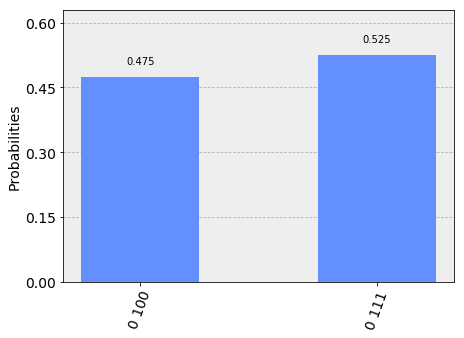

In [12]:
result = ibmsim(qwc)
plot_histogram(result)

## Results

The following animation is what the quantum walk looks like over its 19 iterations. The size of each node represents probability of the quantum walker existing in that position. 

<img src="../images/quantum_walk/fast.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="center">

## Required Resources

In this  algorithm, we needed $n+1$ qubits for a cycle graph with $2^n$ nodes. As you can see in the following graph, the time complexity increases linearly. This is the result of relation between execution time on 'qasm_simulator' and the number of steps.

<img src="../images/quantum_walk/executiontime.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="center">

## Discussion about Future Work and Applications
_Expansion of number of nodes on graph_ 

The walk implemented in this project required 3 qubits for 8 nodes plus an additional 1 qubit for the coin operator. The total time for iterating through coin and shift operator was 16 seconds for 100 flips. 

An example of a real world problem that can be solved using quantum random walks is the mapping of enzymes to understand their evolution when in contact with mutagens. This problem only requires 33 nodes which can be mapped out on 7 qubit circuit. This increase in qubits would increase the total time to 49 seconds for 100 flips. This is a scalable model which can continue to grow to map more complex graphs to problems. 

The time complexity for the quantum simulator approximately follows $({\frac{m+1}{n+1}})^2$ if the number of nodes becomes $2^m$ from $2^n$. This value is based on number of qubits and is roughly estimated. 

## Conclusion
In this notebook we showed the basics of the quantum random walk and its implementation on a cyclic quantum circuit.

The implemented algorithm requires $n+1$ qubits for any cycle graph with $2^n$ nodes. 